# Gradient-boosted trees - XGBoost library

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. The simplest way to apply machine learning techniques to the problem would be to use a similar structure to iMeta, which is a decision tree, but use standard ML training techiniques to learn the parameters such as what thresholds to use and how many branches/leaves to have in the tree for the best results. Gredient boosted trees are the current state of the art in decision tree ensembles, so a natural extension to the manual imeta tree approach.

In [1]:
import os
import sys
import pathlib
import functools
import itertools
import random

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [4]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [5]:
import ipywidgets
import time

In [6]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [7]:
import xgboost

In [8]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [9]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [10]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
print(environment)

local


In [11]:
try:
    root_data_dir = os.environ['XBT_ROOT_DIR']
except KeyError:
    root_data_dir = '/data/users/shaddad/xbt-data/',
    
year_range = (1966,2015)
print(root_data_dir)
print(year_range)

/Users/stephen.haddad/data/xbt-data/
(1966, 2015)


In [12]:
metrics_avg = 'weighted'
cv_metric_names = [f'recall_{metrics_avg}', f'precision_{metrics_avg}', f'f1_{metrics_avg}']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']
target_feature_name = 'instrument'

In [13]:
splitter_features = ['year', 'instrument']
test_feature = 'cruise_number'
ensemble_test_fraction = 0.1
num_test_splits = 3
test_fraction = 1.0 / num_test_splits
num_train_splits = 3
train_fraction = 1.0 - (1.0 / num_train_splits)
test_fold_name = 'test_fold'

In [14]:
input_dir_name = 'dask_clean'
exp_out_dir_name = 'experiment_outputs'

In [15]:
experiment_name = 'nb_cv_xgboost'
classifier_name = 'xgboost'
suffix='countryAndLatLon'

In [16]:
classifier_opts = {'xgboost': {
                       'opts':  {'objective':'binary:logistic', 
                                 'n_estimators':2},
                       'class': xgboost.XGBClassifier,
                   },
                  }

In [17]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [18]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /Users/stephen.haddad/data/xbt-data/experiment_outputs/nb_cv_xgboost


In [19]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [20]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 5.3 s, sys: 1.13 s, total: 6.43 s
Wall time: 6.53 s


## Data preparation

We are only testing on the labelled data, to be able to evaluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

Our training and evaluation will all happen within the labelled dataset, but ultimately we want to apply the trained ML algorithms to the unlabelled data, as this is where labels are needed to reduce the uncertainty in the ocean temperature dataset. So we need to design our experiment with this in mind. What we need to know is how well does our chosen algorithm generalise to unseen data. 

So within the labelled dataset we split the data into three groups. Firstly, we set a side some fraction of cruises and all profiles that are from those cruises into a group called "unseen". These profiles will not be used in the training or initial evaluation. These will represent cruises that have no labelled data. 

The remainder of the data will then be split into 2 groups, training and test as is standard for a machine learning pipeline. In splitting the data, we will sample a certain fraction of the profiles for train and the rest will be test. But we don't sample from the whole dataset randomly, as this might result in imbalances in representations of years and instrment types. Rather, for each combination of year and instrument label, sample the required fraction from all profiles matching those values. Doing this all possisble value combination of those 2 parameters should results in all years and instrument type being as well represented as possible in both the test and train sets.

So the algorithm will be fit to the training set. Then we will evaulate performance on the test set. This gives us an idea of how the algorithm will perform on unlabelled profiles where other profiles from the same cruise are labelled. Then we will evaluate performance of the algorithm on the unseen dataset. This suggests how the algorithm will perform on unlabelled profiles where no profiles from that cruise are labelled. Both of these sorts of profiles have been found to be present in the unlabelled data, so it is important to evaluate the algorithm for both cases.

In [21]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 217 ms, sys: 80.3 ms, total: 297 ms
Wall time: 296 ms


The format of the data in the pandas dataframe is not suitable for feeding into the machine learning algorithms. We have to appropriately encode the data for training. The dataset class has knowledge of the different types of data represented and how each type should be encoded. This happens through the get_ml_dataset method. Calling this with the return_data flag as False doesn't actually encode the data, but initialises the encoder objects required. These encoders are then used for subsequent encoding operations, so encoding are consistent for the whole experiment and results can be compared.

In [22]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [23]:
_ = xbt_labelled.filter_features(['instrument', 'model', 'manufacturer']).encode_target(return_data = False)

In [24]:
%%time
test_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)
test_var_name = 'test'
test_part_name = 'test_part'
test_whole_name = 'test_whole'
test_indices = list(itertools.chain.from_iterable([list(xbt_labelled.filter_obs({target_feature_name: selected_instrument}).xbt_df.sample(frac=0.1).index) 
for selected_instrument in xbt_labelled['instrument'].unique()]))

CPU times: user 1.05 s, sys: 47.1 ms, total: 1.1 s
Wall time: 1.1 s


In [25]:
# label test data based on whole cruises set aside
xbt_labelled.xbt_df[test_var_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)
xbt_labelled.xbt_df[test_whole_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)

In [26]:
# label test data where part of the cruise is in the train/validation sets
xbt_labelled.xbt_df.loc[test_indices, test_var_name] = True
xbt_labelled.xbt_df[test_part_name] = False
xbt_labelled.xbt_df.loc[test_indices, test_part_name] = True


In [27]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [28]:
imeta_feature_name = f'{target_feature_name}_imeta'

In [29]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 
xbt_labelled.xbt_df[imeta_feature_name] = imeta_instrument
xbt_labelled._target_encoders[imeta_feature_name] = xbt_labelled._target_encoders[target_feature_name]
xbt_labelled._feature_encoders[imeta_feature_name] = xbt_labelled._feature_encoders[target_feature_name]

In [30]:
%%time
xbt_test = xbt_labelled.filter_obs({test_var_name: True})
xbt_working = xbt_labelled.filter_obs({test_var_name: False})

CPU times: user 103 ms, sys: 23 ms, total: 126 ms
Wall time: 125 ms


alskdaslkdjalsdk

In [31]:
xbt_test_whole = xbt_labelled.filter_obs({test_whole_name: True})
xbt_test_part = xbt_labelled.filter_obs({test_part_name: True})

In [32]:
X_working_all = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_working_all = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]

In [33]:
X_test_all = xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_test_all = xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0]

## Training the classifier

* [XGBoost Classsifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn) 

In [34]:
%%time
xbt_working.generate_folds_by_feature('cruise_number', num_test_splits, test_fold_name)

CPU times: user 14.1 s, sys: 55.9 ms, total: 14.1 s
Wall time: 14.1 s


In [35]:
cruise_numbers = list(xbt_working['cruise_number'].unique())

In [36]:
X_labelled = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]

In [37]:
clf_name = 'xgboost'
clf_params = classifier_opts[clf_name]

In [38]:
scores = {}

In [39]:
%%time 
group_cv1 = sklearn.model_selection.KFold(n_splits=num_test_splits,
                                          shuffle=True,
                                          random_state=random.randint(1,2**20))

clf_dt1 = clf_params['class'](**clf_params['opts'])
scores[clf_name] = sklearn.model_selection.cross_validate(
    clf_dt1,
    X_labelled, y_labelled, 
    groups=xbt_working[test_fold_name], 
    cv=group_cv1,
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metric_names,
    n_jobs=-1,
)

CPU times: user 211 ms, sys: 290 ms, total: 502 ms
Wall time: 50.5 s


In [40]:
d1 = {
    f'{target_feature_name}_{clf_name}_res_cv_{ix1}': 
    xbt_test._feature_encoders[target_feature_name].inverse_transform(
        clf1.predict(xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]))
    for clf_name, scores_clf in scores.items()
    for ix1, clf1 in enumerate(scores_clf['estimator']) 
}
d1['id'] = xbt_test['id']
instr_predictions_test_cv = pandas.DataFrame(d1)

In [41]:
ens_res_features_cv = [f'{target_feature_name}_{clf_name}_res_cv_{ix1}' for ix1, clf1 in enumerate(scores[clf_name]['estimator'])]

In [42]:
xbt_test.xbt_df = pandas.DataFrame.merge(xbt_test.xbt_df, instr_predictions_test_cv, on='id')

In [43]:
calc_disagreements = lambda x: len(set(x))

In [44]:
%%time
vote_counts_cv_df = pandas.DataFrame.from_records( 
    {year1: 
     dict(xbt_test.filter_obs({'year': year1}).filter_features(ens_res_features_cv).xbt_df.apply(
         calc_disagreements, axis='columns').value_counts()) for year1 in range(*year_range)},
).transpose().fillna(0.0)
vote_counts_cv_df['year'] = vote_counts_cv_df.index

CPU times: user 1.39 s, sys: 52.3 ms, total: 1.45 s
Wall time: 1.45 s


In [45]:
probs_test_instrument_cv = functools.reduce(
    lambda x,y: x+y, 
    [xbt_labelled._target_encoders[target_feature_name].transform(instr_predictions_test_cv[[pred1]])
     for pred1 in instr_predictions_test_cv.columns 
     if 'res_cv' in pred1]) / len(instr_predictions_test_cv.columns)
probs_test_instrument_cv_df = pandas.DataFrame({col_name: probs_test_instrument_cv[:,col_ix1]
for col_ix1, col_name in enumerate(xbt_labelled._target_encoders[target_feature_name].categories_[0])})

In [46]:
max_prob_cv_ensemble = probs_test_instrument_cv_df.idxmax(axis='columns')

In [47]:
clf_dict_cv = {ix1: clf1 for ix1, clf1 in enumerate(scores[clf_name]['estimator'])}

## Calculate metrics

In [48]:
def calc_metric_subset(xbt_subset, clf1, filter_dict, inputs, target_feature, metric_func, metric_args_dict):
    if filter_dict:
        xbt_selected = xbt_subset.filter_obs(filter_dict)
    else:
        xbt_selected = xbt_subset
    if xbt_selected.shape[0] == 0:
        return 0.0
    metrics_result = metric_func(
        clf1.predict(xbt_selected.filter_features(inputs).get_ml_dataset()[0]),
        xbt_selected.filter_features([target_feature]).get_ml_dataset()[0],
        **metric_args_dict)
    return metrics_result                       

In [49]:
instrument_list = list(xbt_labelled._feature_encoders[target_feature_name].classes_)

In [50]:
do_avg_args_dict = {'labels':list(range(0,len(instrument_list))), 
                    'average':'weighted'}
metrics_defs_dict = {
    'recall': {'metric_func': sklearn.metrics.recall_score, 'metric_args_dict': do_avg_args_dict},
    'precision': {'metric_func': sklearn.metrics.precision_score, 'metric_args_dict': do_avg_args_dict},
    'accuracy': {'metric_func': sklearn.metrics.accuracy_score, 'metric_args_dict': {}},
    'f1': {'metric_func': sklearn.metrics.f1_score, 'metric_args_dict': do_avg_args_dict},
    'balanced_accuracy': {'metric_func': sklearn.metrics.balanced_accuracy_score, 'metric_args_dict': {}},    
}


In [51]:
metrics_imeta_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test.filter_features([f'{target_feature_name}_imeta']).get_ml_dataset()[0],
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_imeta_all['classifier'] = 'imeta'

In [52]:
%%time
metrics_test_cv_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) for res_ix1, clf1 in clf_dict_cv.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_cv_ens['classifier'] = [
    f'cv_{res_ix1}' for res_ix1, clf1 in clf_dict_cv.items()]

CPU times: user 34.2 s, sys: 1.05 s, total: 35.3 s
Wall time: 5.62 s


In [53]:
metrics_test_cv_ens

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.915172,0.920992,0.915172,0.917155,0.820709,cv_0
1,0.913528,0.919548,0.913528,0.915608,0.809038,cv_1
2,0.914448,0.920036,0.914448,0.916375,0.779477,cv_2


In [54]:
%%time
metrics_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_cv.items()
}
metrics_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                       for fn1 in instrument_list]
metrics_raw_cv_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_cv_df = pandas.DataFrame(metrics_raw_cv_dict)
metrics_per_class_cv_df = metrics_per_class_cv_df.sort_values('num_profiles', ascending=False)
for metric_name in metrics_defs_dict.keys(): 
    metrics_per_class_cv_df[f'{metric_name}_instr_avg'] = metrics_per_class_cv_df[[c1 for c1 in metrics_per_class_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 3min 12s, sys: 3.35 s, total: 3min 16s
Wall time: 26.1 s


In [55]:
metrics_per_class_cv_df

,recall_instr_0,recall_instr_1,recall_instr_2,precision_instr_0,precision_instr_1,precision_instr_2,accuracy_instr_0,accuracy_instr_1,accuracy_instr_2,f1_instr_0,...,balanced_accuracy_instr_0,balanced_accuracy_instr_1,balanced_accuracy_instr_2,num_profiles,instrument,recall_instr_avg,precision_instr_avg,accuracy_instr_avg,f1_instr_avg,balanced_accuracy_instr_avg
9,0.972393,0.971649,0.972621,0.945548,0.944102,0.945991,0.972393,0.971649,0.972621,0.958782,...,0.111111,0.111111,0.100000,448238,XBT: T4 (SIPPICAN),0.972221,0.945214,0.539814,0.958527,0.107407
2,0.952621,0.952604,0.949542,0.907487,0.907455,0.901631,0.952621,0.952604,0.949542,0.929507,...,0.100000,0.100000,0.090909,305512,XBT: DEEP BLUE (SIPPICAN),0.951589,0.905524,0.524279,0.927985,0.096970
15,0.792019,0.793691,0.796373,0.627294,0.629946,0.634209,0.792019,0.793691,0.796373,0.700097,...,0.071429,0.071429,0.076923,192456,XBT: T7 (SIPPICAN),0.794027,0.630483,0.433644,0.702866,0.073260
6,0.847122,0.825075,0.824964,0.717615,0.680749,0.680565,0.847122,0.825075,0.824964,0.777009,...,0.090909,0.090909,0.090909,41666,XBT: T10 (SIPPICAN),0.832387,0.692976,0.461648,0.756281,0.090909
16,0.727885,0.736673,0.729057,0.529817,0.542686,0.531524,0.727885,0.736673,0.729057,0.613255,...,0.083333,0.100000,0.100000,17588,XBT: T7 (TSK - TSURUMI SEIKI Co.),0.731205,0.534676,0.412825,0.617680,0.094444
14,0.942686,0.925457,0.953938,0.888658,0.856471,0.909998,0.942686,0.925457,0.953938,0.914875,...,0.111111,0.111111,0.100000,15559,XBT: T6 (TSK - TSURUMI SEIKI Co.),0.940694,0.885042,0.524051,0.911985,0.107407
11,0.685804,0.682265,0.689343,0.470327,0.465486,0.475194,0.685804,0.682265,0.689343,0.557986,...,0.100000,0.100000,0.100000,14413,XBT: T5 (SIPPICAN),0.685804,0.470336,0.392902,0.557989,0.100000
10,0.901515,0.886364,0.901515,0.812730,0.785640,0.812730,0.901515,0.886364,0.901515,0.854823,...,0.200000,0.166667,0.166667,7685,XBT: T4 (TSK - TSURUMI SEIKI Co.),0.896465,0.803700,0.537121,0.847538,0.177778
13,0.509294,0.448575,0.509294,0.259380,0.201220,0.259380,0.509294,0.448575,0.509294,0.343711,...,0.071429,0.076923,0.076923,5986,XBT: T6 (SIPPICAN),0.489054,0.239993,0.282073,0.321746,0.075092
4,0.758767,0.759830,0.783209,0.575728,0.577342,0.613417,0.758767,0.759830,0.783209,0.654695,...,0.200000,0.200000,0.200000,4481,XBT: FAST DEEP (SIPPICAN),0.767269,0.588829,0.483634,0.666273,0.200000


In [56]:
%%time
metrics_annual_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_cv.items()
}
metrics_annual_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_cv_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_cv_df = pandas.DataFrame(metrics_annual_raw_cv_dict)
for metric_name in metrics_defs_dict.keys(): 
    metrics_annual_cv_df[f'{metric_name}_instr_avg'] = metrics_annual_cv_df[[c1 for c1 in metrics_annual_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 5min 9s, sys: 8.04 s, total: 5min 17s
Wall time: 43.3 s


# Classification result plots


In [57]:
metrics_annual_cv_df.columns

Index(['recall_instr_0', 'recall_instr_1', 'recall_instr_2',
       'precision_instr_0', 'precision_instr_1', 'precision_instr_2',
       'accuracy_instr_0', 'accuracy_instr_1', 'accuracy_instr_2',
       'f1_instr_0', 'f1_instr_1', 'f1_instr_2', 'balanced_accuracy_instr_0',
       'balanced_accuracy_instr_1', 'balanced_accuracy_instr_2',
       'num_profiles', 'year', 'recall_instr_avg', 'precision_instr_avg',
       'accuracy_instr_avg', 'f1_instr_avg', 'balanced_accuracy_instr_avg'],
      dtype='object')

<AxesSubplot:xlabel='year'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


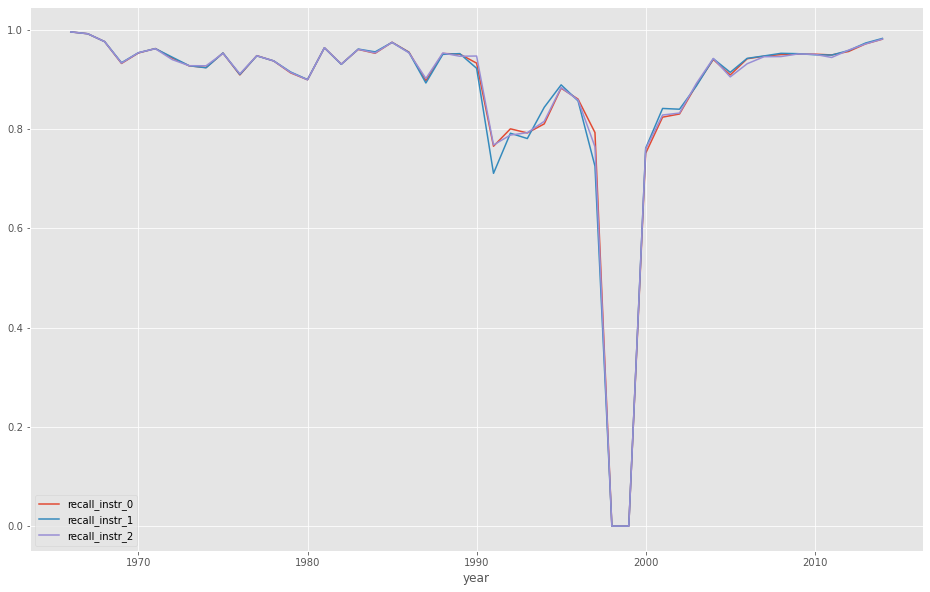

In [58]:
fig1 = matplotlib.pyplot.figure('recall_per_year', figsize=(16,10))
ax1 = fig1.add_subplot(1,1,1)
metrics_annual_cv_df.plot.line(x='year', 
                               y=['recall_instr_0', 'recall_instr_1', 'recall_instr_2'], 
                               ax=ax1,
                              )

<AxesSubplot:xlabel='instrument'>

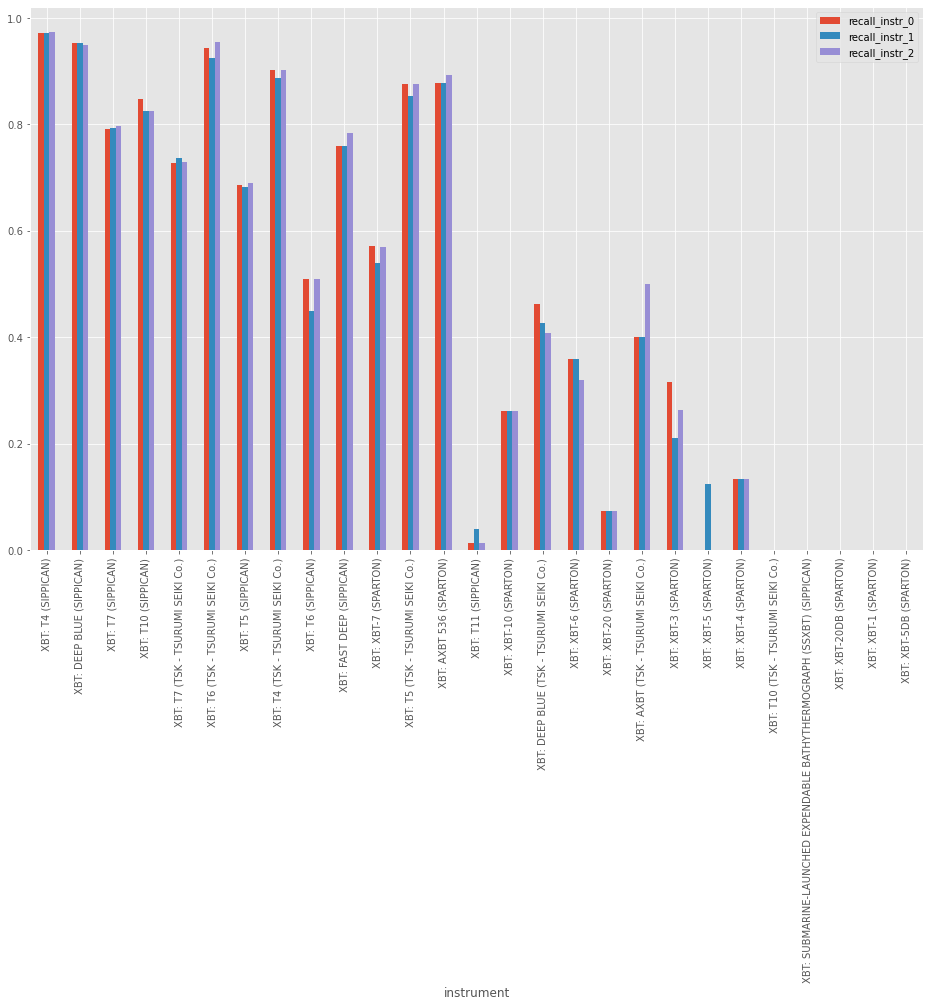

In [59]:
fig1 = matplotlib.pyplot.figure('recall_per_class', figsize=(16,10))
ax1 = fig1.add_subplot(1,1,1)
metrics_per_class_cv_df.plot.bar(x='instrument', 
                                 y=['recall_instr_0', 'recall_instr_1', 'recall_instr_2'], 
                                 ax=ax1,
                              )

<AxesSubplot:xlabel='instrument'>

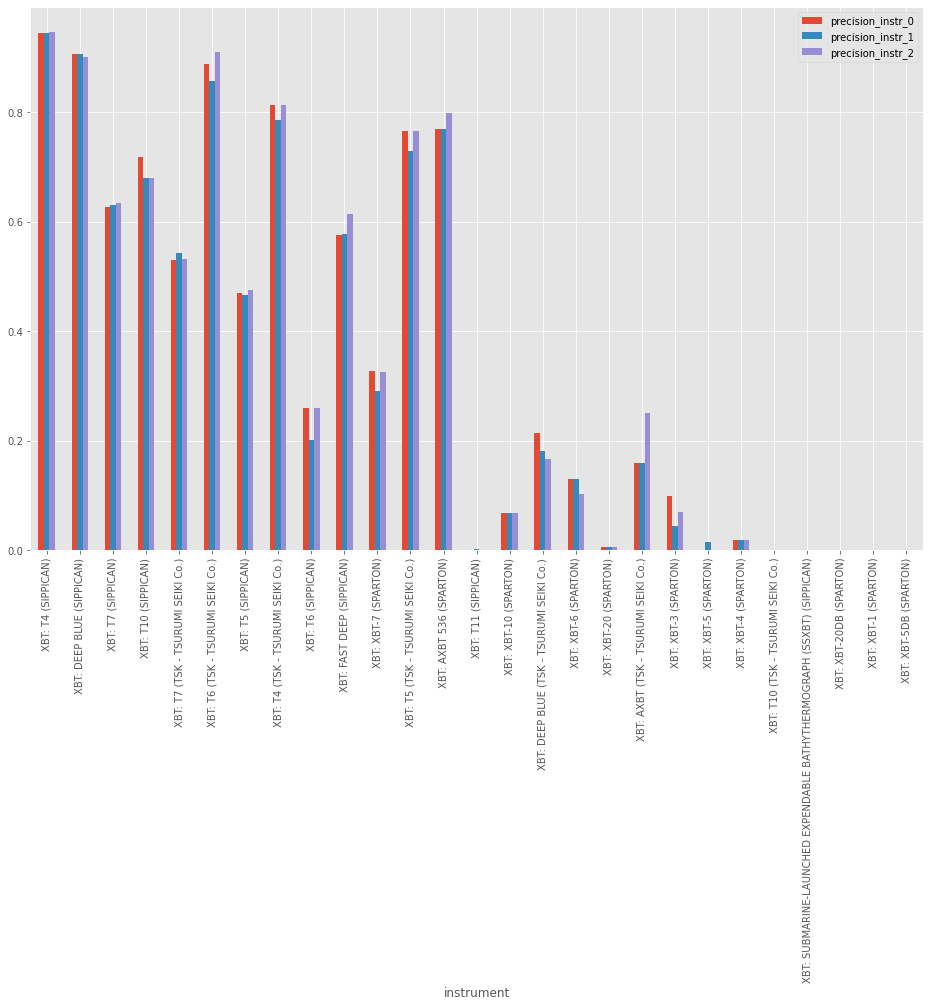

In [70]:
fig1 = matplotlib.pyplot.figure('precision_per_class', figsize=(16,10))
ax1 = fig1.add_subplot(1,1,1)
metrics_per_class_cv_df.plot.bar(x='instrument', 
                                 y=['precision_instr_0', 'precision_instr_1', 'precision_instr_2'], 
                                 ax=ax1,
                              )

In [61]:
metrics_per_class_cv_df.columns

Index(['recall_instr_0', 'recall_instr_1', 'recall_instr_2',
       'precision_instr_0', 'precision_instr_1', 'precision_instr_2',
       'accuracy_instr_0', 'accuracy_instr_1', 'accuracy_instr_2',
       'f1_instr_0', 'f1_instr_1', 'f1_instr_2', 'balanced_accuracy_instr_0',
       'balanced_accuracy_instr_1', 'balanced_accuracy_instr_2',
       'num_profiles', 'instrument', 'recall_instr_avg', 'precision_instr_avg',
       'accuracy_instr_avg', 'f1_instr_avg', 'balanced_accuracy_instr_avg'],
      dtype='object')

<AxesSubplot:xlabel='instrument'>

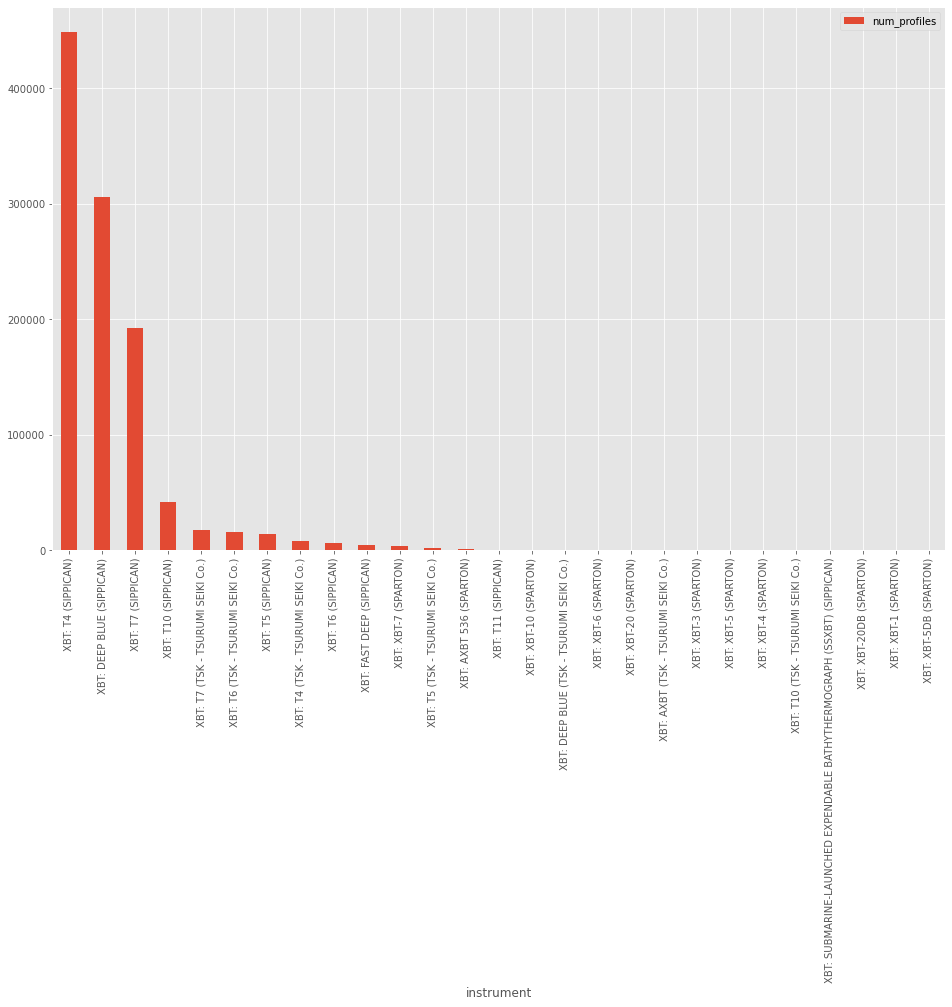

In [62]:
fig1 = matplotlib.pyplot.figure('recall_per_class', figsize=(16,10))
ax1 = fig1.add_subplot(1,1,1)
metrics_per_class_cv_df.plot.bar(x='instrument', 
                                 y=['num_profiles'], 
                                 ax=ax1,
                              )

In [71]:
metrics_avg_all = {'precision': [], 
                   'recall': [],
                   'f1': [],
                   'support': [],
                   'classifier_num':[],
                  }
for clf_ix1, clf1 in clf_dict_cv.items():
    p1, r1, f1, s1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, 
                                                    clf1.predict(X_test_all),
                                                    average='micro',
                                                   )
    metrics_avg_all['precision'] += [p1]
    metrics_avg_all['recall'] += [r1]
    metrics_avg_all['f1'] += [f1]
    metrics_avg_all['support'] += [s1]
    metrics_avg_all['classifier_num'] += [clf_ix1]
metrics_avf_df = pandas.DataFrame(metrics_avg_all)

In [75]:
metrics_avf_df

,precision,recall,f1,support,classifier_num
0,0.915172,0.915172,0.915172,None,0
1,0.913528,0.913528,0.913528,None,1
2,0.914448,0.914448,0.914448,None,2


<AxesSubplot:xlabel='classifier_num'>

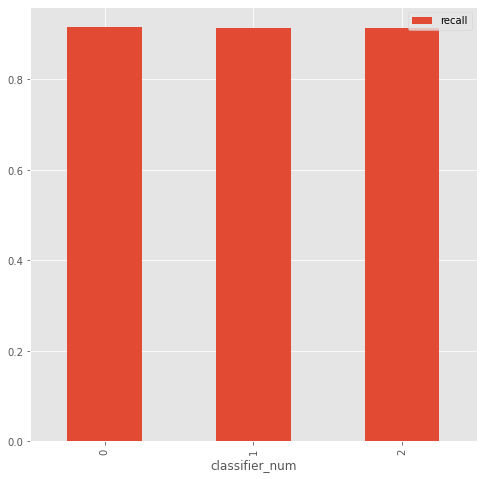

In [72]:
metrics_avf_df.plot.bar(x='classifier_num',
                        y='recall',
                        figsize=(8,8),
                       )

We see substantial improvements in recall some years, particularly the early 1990s. This is a postive outcome as this where the high percent of unlabelled data is found.

In [ ]:
res_ml1 = clf_dt_instr1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [ ]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [ ]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               feature_encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                                target_encoders={result_feature_name: xbt_labelled._target_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [ ]:
%%time
xbt_full_dataset.output_data(os.path.join(output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             target_features=[result_feature_name])